# C1-Week4 : Titanic Classifier

## 1- Import Package

In [1]:
import numpy as np
import h5py   # to load dataset in .h5 format file
import requests
import zipfile
from pathlib import Path
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from sklearn.utils import shuffle

from dnn_utils import *

## 2- Dataset
+ Unfortunately the given **Cat dataset** of this course (Deep-Learning Specialization by Andrew NG) was corrupted, So I randomly choose a [kaggle Cat vs Dog dataset](https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification)

+ The goal here is the same as **Cat Classifier** (is cat/is not cat), so train a **Cat or Dog Classifier** (isCat/ isNotCat-isDog)
### 2.1- Loading train and test dataset
1. Check the dataset.h5 error.
2. Check for existance of the new dataset.
3. Make a directory and start downloading from kaggle.
4. Unzip the downloaded zipfile in it created directory

**NOTE**: I have already downloaded the zipfile for Iranian friends who will have hard time downloading from kaggle! if you prefer downloading from source, you can simply uncomment the give command,
```!kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification```

In [2]:
try:
    train_dataset = h5py.File('CatDataset/test_catvnoncat.h5', 'r')
    test_dataset = h5py.File('CatDataset/test_catvnoncat.h5')
except Exception as e:
    print('[NOTE] I was not able to read the given dataset, the error is:\n',e)

[NOTE] I was not able to read the given dataset, the error is:
 Unable to open file (file signature not found)


In [3]:
data_path = Path('./CatDogDataset/')

if data_path.is_dir():
    print(f"[NOTE] {data_path} directory exists.")
else:
    print(f"[NOTE] Did not find {data_path} directory, creating one...")
    data_path.mkdir()

    # Download dataset from kaggle
    print('[NOTE] Start downloading dataset from kaggle.')
    # !kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification

    # Unzip Cat vs Dog dataset
    with zipfile.ZipFile('cats-and-dogs-image-classification.zip', 'r') as zip_file:
        print('[NOTE] Unzipping the dataset')
        zip_file.extractall(data_path)
        zip_file.close()

[NOTE] CatDogDataset directory exists.


### 2.2- Data preparation
1. inspect what's in CatDogDataset directory by writing a helper function to walk through each of the subdirectories and count the files present, so:
    + **training set**: 279 cats and 278 dogs
    + **testing set**: 70 cats and 70 dogs

In [4]:
def walk_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print('There are {} directories & {} files in {}'
              .format(len(dirnames), len(filenames), dirpath))

In [5]:
walk_dir(data_path)

There are 2 directories & 0 files in CatDogDataset
There are 2 directories & 0 files in CatDogDataset/train
There are 0 directories & 279 files in CatDogDataset/train/cats
There are 0 directories & 278 files in CatDogDataset/train/dogs
There are 2 directories & 0 files in CatDogDataset/test
There are 0 directories & 70 files in CatDogDataset/test/cats
There are 0 directories & 70 files in CatDogDataset/test/dogs


In [6]:
train_dir = data_path / 'train'
test_dir = data_path / 'test'

train_dir, test_dir

(PosixPath('CatDogDataset/train'), PosixPath('CatDogDataset/test'))

### 2.3- Data Exploration (Image Visualization)
1. Get the list of all images using `.glob()` which Iterate over give subtree and yield all existing files.
2. turn images into numpy array then plot it.

In [7]:
data_path_list = list(data_path.glob('*/*/*.jpg'))
print('Nnumber of images: ',len(data_path_list))

Nnumber of images:  697


The path of random image CatDogDataset/test/dogs/dog_344.jpg
The class of random image dogs
heigh:340 | width:343


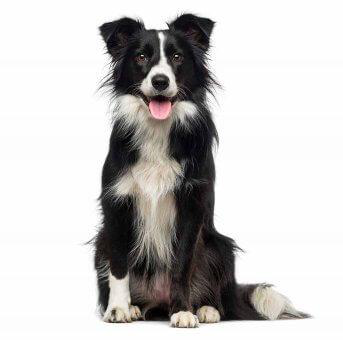

In [8]:
# random.seed(1)

random_data_path = random.choice(data_path_list)
data_class = random_data_path.parent.stem
img = Image.open(random_data_path)

print('The path of random image', random_data_path)
print('The class of random image', data_class)
print('heigh:{} | width:{}'.format(img.height, img.width))
img

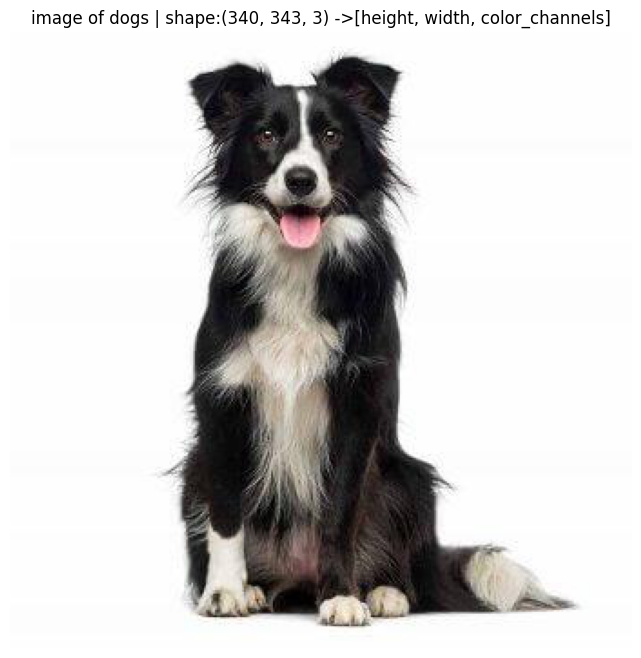

In [9]:
img = np.asarray(img)

plt.figure(figsize=(12,8))
plt.imshow(img)
plt.title('image of {} | shape:{} ->[height, width, color_channels]'
          .format(data_class, img.shape))
plt.axis(False);

In [10]:
def display_image(img, label):
    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.title('image of {} | shape:{} ->[height, width, color_channels]'
            .format(label, img.shape))
    plt.axis(False);

### 2.4- Data Transformation
Define a `batch_images_to_arrays` function that: 
1. takes a list of image file paths, 
2. resizes each image, and 
3. converts them to NumPy arrays using parallel processing with multiple CPU cores
4. Normalize each pixel [0, 255] to have range of [0, 1]

In [11]:
def image_to_array(filepath, width, height):
    with Image.open(filepath) as img:
        return np.array(img.convert('RGB').resize((width, height)), dtype=np.float32)/255.0, 1 if filepath.parent.stem == 'cats' else 0
    
def batch_to_arrays(batch_file_paths, width, height):
    with Pool(processes=cpu_count()) as pool:
        return zip(*pool.starmap(image_to_array, [(file, width, height) 
                                             for file in batch_file_paths]))

In [12]:
train_path = list(train_dir.glob('*/*.jpg'))
width, height = 64, 64

X_train, y_train = batch_to_arrays(train_path, width, height)
X_train, y_train = shuffle(np.array(X_train), np.array(y_train))
print('X_train:{} | y_train:{}'.format(X_train.shape, y_train.shape))

X_train:(557, 64, 64, 3) | y_train:(557,)


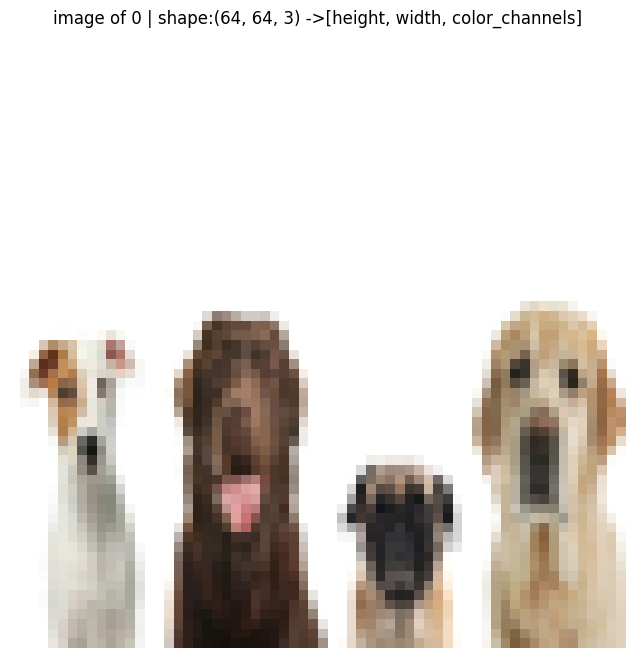

In [13]:
index = random.randint(0, len(X_train))
display_image(X_train[index], y_train[index])

In [14]:
test_path = list(test_dir.glob('*/*.jpg'))

X_test, y_test = batch_to_arrays(test_path, width, height)
X_test, y_test = np.array(X_test), np.array(y_test)
print('X_test:{} | y_test:{}'.format(X_test.shape, y_test.shape))

X_test:(140, 64, 64, 3) | y_test:(140,)


In [15]:
# reshape and flatten the data
# The "-1" makes reshape flatten the remaining dimensions
X_train_flatt = X_train.reshape(X_train.shape[0], -1).T
X_test_flatt = X_test.reshape(X_test.shape[0], -1).T

print('shapes of flattened X_train:{} | X_test{}'
      .format(X_train_flatt.shape, X_test_flatt.shape))

shapes of flattened X_train:(12288, 557) | X_test(12288, 140)


## 3 - Architecture of model
### 3.1 - L-layer neural network
<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure above</u>:
1. The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
2. The **input vector**: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the **weight matrix** $W^{[1]}$ of first layer and then you add the **intercept** $b^{[1]}$. The result is called the **linear unit**.
3. Next, you take the **relu** of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
4. Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

**Question**: Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_params(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [16]:
layer_dims = [64*64*3, 20, 7, 5, 1]
layer_dims

[12288, 20, 7, 5, 1]

In [20]:
def L_layer_model(X, y, layer_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    costs = []

    # parameter initialization
    parameters = initialize_params(layer_dims)

    # loop - Gradient descent
    for i in range(0, num_iterations):
        
        # Forward Propagation
        AL, caches = L_model_forward(X, parameters)

        # Compute cost
        cost = compute_cost(AL, y)

        # Backward Propagation
        grads = L_model_backward(AL, y, caches)

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print('Cost after iteration {}: {}'.format(i, cost))
            costs.append(cost)

    # plot cost per iteration
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 100)')
    plt.title('learning rate:{}'.format(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.7235574031316316
Cost after iteration 100: 0.6696430995768758
Cost after iteration 200: 0.652935281963849
Cost after iteration 300: 0.6376218586992815
Cost after iteration 400: 0.590966699131686
Cost after iteration 500: 0.5871494985790108
Cost after iteration 600: 0.6281836077442454
Cost after iteration 700: 0.5333127837949607
Cost after iteration 800: 0.5057061583130623
Cost after iteration 900: 0.6035915254068971
Cost after iteration 1000: 0.43537599721689735
Cost after iteration 1100: 0.44176513817631624
Cost after iteration 1200: 0.41354181500116394
Cost after iteration 1300: 0.424810532897338
Cost after iteration 1400: 0.4805177342950096
Cost after iteration 1500: 0.38736756308279013
Cost after iteration 1600: 0.36006227377931915
Cost after iteration 1700: 0.2842891312129187
Cost after iteration 1800: 0.37942096566446887
Cost after iteration 1900: 0.43871290205794533
Cost after iteration 2000: 0.36023633254447496
Cost after iteration 2100: 0.314420240850

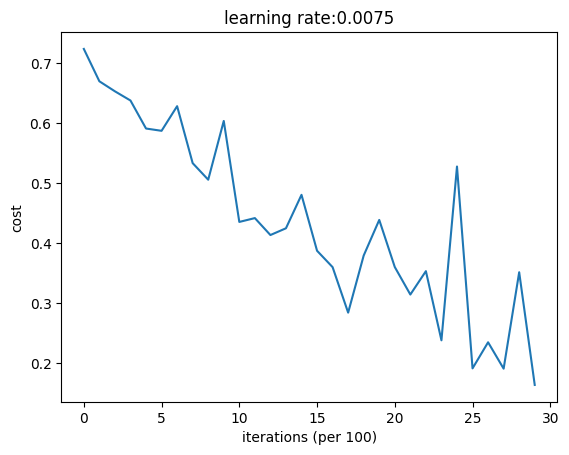

In [21]:
params = L_layer_model(X_train_flatt, y_train, layer_dims, learning_rate=0.0075, print_cost=True)

## 4- Result Analysis

In [32]:
def predict(X, y, parameters):
    m = X.shape[1]
    probas, _ = L_model_forward(X, parameters)
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            probas[0,i] = 1
        else:
            probas[0,i] = 0
    # print (f"predictions: {probas}")
    # print (f"true labels: {y}")
    print(f"Accuracy: {np.sum((probas == y)/m)}")
    return probas

pred_train = predict(X_train_flatt, y_train, params)

Accuracy: 0.9712746858168761


In [33]:
pred_test = predict(X_test_flatt, y_test, params)

Accuracy: 0.6214285714285714


In [34]:
False + True

1

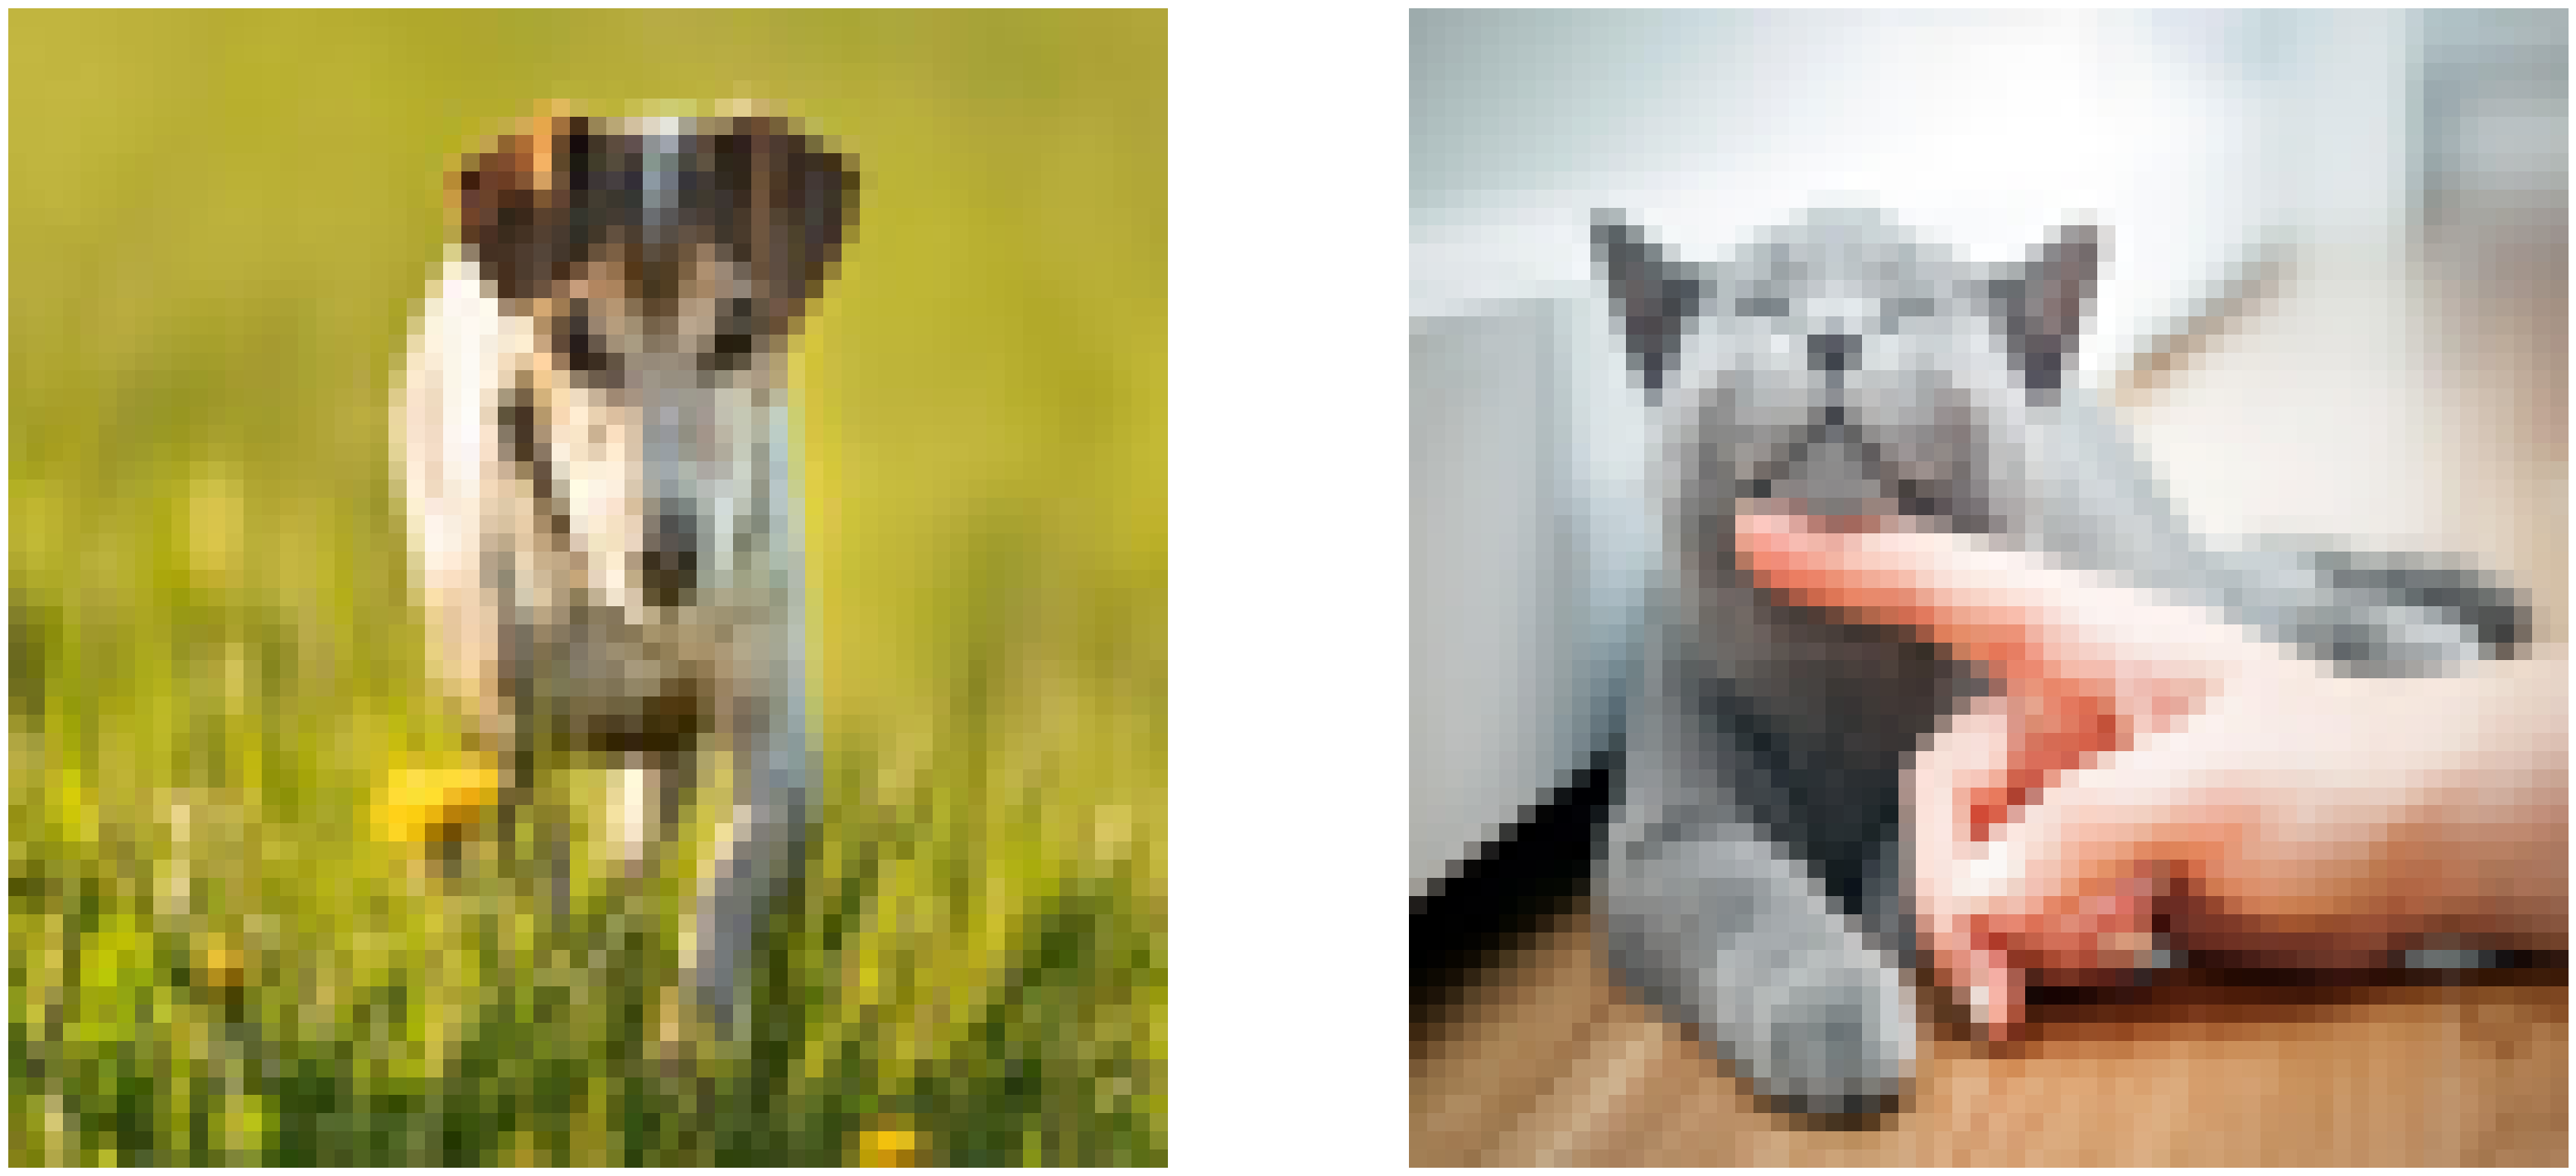

In [44]:
indecies = np.asarray(np.where(pred_test + y_test==1))
plt.rcParams['figure.figsize'] = (40, 40)

for i in range(len(indecies)):
    index = indecies[1][i]

    plt.subplot(2, len(indecies), i+1)
    plt.imshow(X_train_flatt[:, index].reshape(64, 64, 3), interpolation='nearest')
    plt.axis('off')